# Deep Learning Model: Convolutional Neural Network
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

**Overall Plan:**
1. Create CNN on unbalanced data.
2. Create CNN with weighted classes.
3. Create CNN using focal loss.

**Plan:**
1. Use Keras to create network.
2. Define CNN architecture.
3. Train model on unbalanced data.
4. Evaluate performance.

In [38]:
import sys
sys.path.append('..')
from time import time

from keras import layers
from keras import metrics
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from src.data_setup import make_dataset as md

%matplotlib inline

## Load Data
Load the pickled training and test data.

In [2]:
X_train, X_test, y_train, y_test = md.load_train_test()

In [3]:
X_train.shape

(123195, 2304)

## Data Preparation
### Unflatten
Unflatten the feature arrays, converting them back into arrays of 2-dimensional images.

In [4]:
def unflatten(X):
    dimension = int(np.sqrt(X.shape[1]))
    return X.reshape((len(X), dimension, dimension, 1))

In [5]:
X_train_unflatten = unflatten(X_train)
X_train_unflatten.shape

(123195, 48, 48, 1)

In [6]:
X_test_unflatten = unflatten(X_test)
X_test_unflatten.shape

(3673, 48, 48, 1)

### Normalize
Normalize the features, to values between 0 and 1.

In [7]:
print(f'The maximum value for the training set is {X_train_unflatten.max()}.')
print(f'The maximum value for the test set is {X_test_unflatten.max()}.')

The maximum value for the training set is 255.
The maximum value for the test set is 255.


In [8]:
X_train_normalized = X_train_unflatten / X_train_unflatten.max()
X_test_normalized = X_test_unflatten / X_test_unflatten.max()

In [9]:
print(f'The maximum value for the normalized training set is {X_train_normalized.max()}.')
print(f'The maximum value for the normalized test set is {X_test_normalized.max()}.')

The maximum value for the normalized training set is 1.0.
The maximum value for the normalized test set is 1.0.


### Categories
First, encode the labels to integer values.

In [10]:
label_encodings = {value: i for i, value in enumerate(np.unique(y_train))}

In [11]:
label_encodings

{'BAS': 0,
 'EBO': 1,
 'EOS': 2,
 'KSC': 3,
 'LYA': 4,
 'LYT': 5,
 'MMZ': 6,
 'MOB': 7,
 'MON': 8,
 'MYB': 9,
 'MYO': 10,
 'NGB': 11,
 'NGS': 12,
 'PMB': 13,
 'PMO': 14}

In [12]:
y_train_encoded = pd.Series(y_train).replace(label_encodings).values
y_test_encoded = pd.Series(y_test).replace(label_encodings).values

In [13]:
np.unique(y_train_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [14]:
np.unique(y_test_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Second, encode the integer labels as one-hot vectors.

In [15]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [16]:
y_train_one_hot.shape

(123195, 15)

In [17]:
y_train_one_hot[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

In [18]:
y_test_one_hot.shape

(3673, 15)

In [19]:
y_test_one_hot[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

## Define Model

In [20]:
input_shape = X_train_unflatten.shape[1:]
print(f'The input shape is {input_shape}.')

The input shape is (48, 48, 1).


In [21]:
model_1 = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, kernel_size=(7, 7), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(38, activation='relu'),
    layers.Dense(15, activation='softmax')
])

In [26]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense (Dense)                (None, 600)               778200    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               9

## Train Model

In [22]:
model_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[
                  metrics.Accuracy(),
                  metrics.categorical_accuracy,
                  metrics.Precision(),
                  metrics.Recall()
              ])
model_1.fit(X_train_normalized, y_train, epochs=5, batch_size=64)

Epoch 1/5
1925/1925 [==============================] - 74s 38ms/step - loss: 1.0037 - accuracy: 3.0939e-05 - categorical_accuracy: 0.6678 - precision: 0.8566 - recall: 0.5673
Epoch 2/5
1925/1925 [==============================] - 74s 39ms/step - loss: 0.0675 - accuracy: 0.0021 - categorical_accuracy: 0.9783 - precision: 0.9801 - recall: 0.9765
Epoch 3/5
1925/1925 [==============================] - 74s 39ms/step - loss: 0.0316 - accuracy: 0.0195 - categorical_accuracy: 0.9906 - precision: 0.9911 - recall: 0.9902
Epoch 4/5
1925/1925 [==============================] - 77s 40ms/step - loss: 0.0216 - accuracy: 0.0488 - categorical_accuracy: 0.9940 - precision: 0.9942 - recall: 0.9937
Epoch 5/5
1925/1925 [==============================] - 77s 40ms/step - loss: 0.0182 - accuracy: 0.0855 - categorical_accuracy: 0.9950 - precision: 0.9952 - recall: 0.9950


### Predictions
Make class predictions using the model.

In [23]:
y_pred_train_cnn = model_1.predict(X_train_normalized)
y_pred_cnn = model_1.predict(X_test_normalized)

## Evaluate the Model

In [24]:
print(classification_report(np.argmax(y_train, axis=1), np.argmax(y_pred_train_cnn, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8213
           1       1.00      1.00      1.00      8213
           2       1.00      1.00      1.00      8213
           3       1.00      1.00      1.00      8213
           4       1.00      1.00      1.00      8213
           5       1.00      0.98      0.99      8213
           6       1.00      1.00      1.00      8213
           7       1.00      1.00      1.00      8213
           8       1.00      0.99      0.99      8213
           9       1.00      1.00      1.00      8213
          10       0.97      1.00      0.99      8213
          11       1.00      1.00      1.00      8213
          12       0.99      0.99      0.99      8213
          13       1.00      1.00      1.00      8213
          14       1.00      1.00      1.00      8213

    accuracy                           1.00    123195
   macro avg       1.00      1.00      1.00    123195
weighted avg       1.00   

In [25]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_cnn, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.56      0.31      0.40        16
           2       0.59      0.31      0.40        85
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.91      0.87      0.89       787
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         5
           8       0.70      0.58      0.63       358
           9       0.00      0.00      0.00         8
          10       0.77      0.90      0.83       653
          11       0.00      0.00      0.00        22
          12       0.93      0.97      0.95      1697
          13       0.00      0.00      0.00         4
          14       0.19      0.21      0.20        14

    accuracy                           0.86      3673
   macro avg       0.31      0.28      0.29      3673
weighted avg       0.85   

/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [32]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_cnn, axis=1))

In [35]:
df_cm = pd.DataFrame(cm, index=label_encodings.keys(), columns=label_encodings.keys())

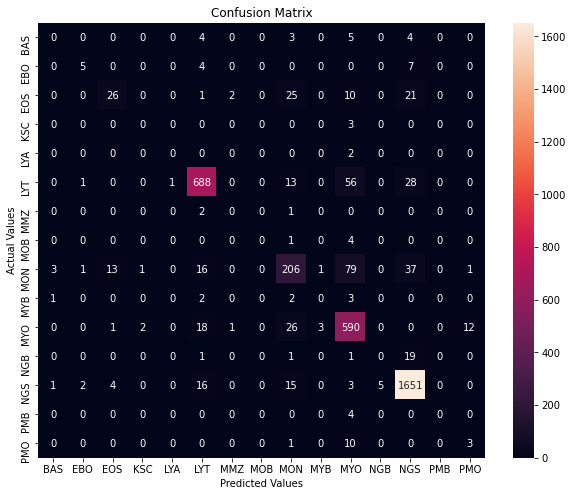

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()